In [44]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [45]:
data = pd.read_csv(r'E:\TrainingProgramOnCollage\GenAI\DatasetProjects\Project4LanguageDetectiion\SavedModel\dataset\Language Detection.csv')

In [46]:
df = data

In [47]:
df.head(3)

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English


In [48]:
df['Language'].unique()

array(['English', 'Malayalam', 'Hindi', 'Tamil', 'Portugeese', 'French',
       'Dutch', 'Spanish', 'Greek', 'Russian', 'Danish', 'Italian',
       'Turkish', 'Sweedish', 'Arabic', 'German', 'Kannada'], dtype=object)

In [49]:
df['Language'].value_counts()

Language
English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil          469
Danish         428
Kannada        369
Greek          365
Hindi           63
Name: count, dtype: int64

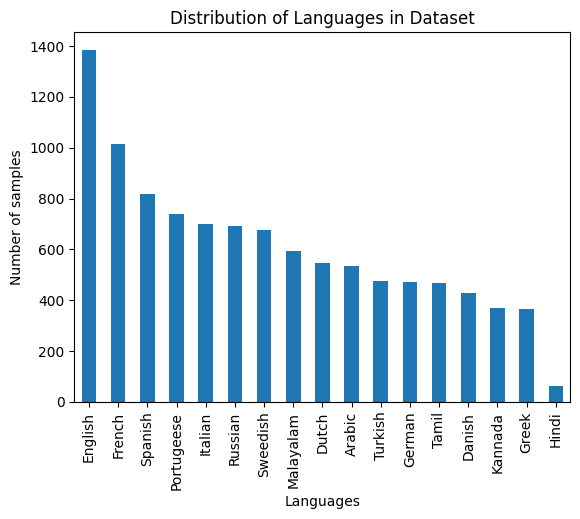

In [50]:
df.Language.value_counts().plot(kind='bar')
plt.xlabel('Languages')
plt.ylabel('Number of samples')
plt.title('Distribution of Languages in Dataset')
plt.show()

In [51]:
label_encoder = LabelEncoder()
df["Language_encoded"] = label_encoder.fit_transform(df["Language"])

In [52]:
print(df.Language.unique())
print(df.Language_encoded.unique())

['English' 'Malayalam' 'Hindi' 'Tamil' 'Portugeese' 'French' 'Dutch'
 'Spanish' 'Greek' 'Russian' 'Danish' 'Italian' 'Turkish' 'Sweedish'
 'Arabic' 'German' 'Kannada']
[ 3 10  7 15 11  4  2 13  6 12  1  8 16 14  0  5  9]


In [53]:
df.head(3)

,Text,Language,Language_encoded
0,"Nature, in the broadest sense, is the natural...",English,3
1,"""Nature"" can refer to the phenomena of the phy...",English,3
2,"The study of nature is a large, if not the onl...",English,3


In [54]:
df.drop("Language_encoded", axis=1, inplace=True)
df["Language"] = label_encoder.fit_transform(df["Language"])

In [55]:
df.head(3)

,Text,Language
0,"Nature, in the broadest sense, is the natural...",3
1,"""Nature"" can refer to the phenomena of the phy...",3
2,"The study of nature is a large, if not the onl...",3


In [56]:
# Tokenization ==> Each word is assigned a unique number (token)
# Keeps only the top 15,000 most frequent words
# Rare words are ignored
# OOV = Out Of Vocabulary ==> Any word not in top 15,000 is replaced by <OOV>
tokenizer = Tokenizer(num_words=15000, oov_token="<OOV>")
# Word-to-Index Mapping ==> 
#   Counts word frequency
#   Assigns indexes based on frequency
tokenizer.fit_on_texts(df["Text"]) # Builds vocabulary dictionary

In [57]:
sequences = tokenizer.texts_to_sequences(df["Text"])
# Converts text sentences into numeric sequences 
sequences[:3]

[[84, 8, 4, 11212, 4937, 22, 4, 704, 2717, 1388, 960, 115, 2718],
 [84, 152, 8008, 14, 4, 11213, 9, 4, 2717, 960, 11, 236, 14, 324, 8, 731],
 [4, 788, 9, 84, 22, 3, 1189, 255, 202, 4, 516, 468, 9, 604]]

In [58]:
X = pad_sequences(sequences, maxlen=60)
X

array([[   0,    0,    0, ...,  960,  115, 2718],
       [   0,    0,    0, ...,  324,    8,  731],
       [   0,    0,    0, ...,  468,    9,  604],
       ...,
       [   0,    0,    0, ...,    1,  650,    1],
       [   0,    0,    0, ...,  136, 8598,    1],
       [   0,    0,    0, ...,    1,  650,    1]], dtype=int32)

In [59]:
X.shape

(10337, 60)

In [60]:
y = df["Language"]

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# We use for balance classes 
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

In [63]:
class_weights = dict(enumerate(class_weights))
class_weights

{0: np.float64(1.1311901504787962),
 1: np.float64(1.3701739850869925),
 2: np.float64(1.1181879648411088),
 3: np.float64(0.444617700828046),
 4: np.float64(0.6118386977432483),
 5: np.float64(1.2902168825089717),
 6: np.float64(1.6377500495147554),
 7: np.float64(9.177580466148724),
 8: np.float64(0.8795872779491544),
 9: np.float64(1.6053193554649583),
 10: np.float64(1.028354682253451),
 11: np.float64(0.817498764211567),
 12: np.float64(0.8748413034278459),
 13: np.float64(0.7381058645005802),
 14: np.float64(0.8957859386848662),
 15: np.float64(1.2733292269787495),
 16: np.float64(1.3181890642435836)}

In [64]:
classes_ = label_encoder.classes_

In [66]:
# SimpleRNN model
model = Sequential([
    # Embedding layer converts words into dense vectors
    # Each word is represented as a 64-dimensional vector
    # vocabulary size = 15000
    # Input sequence length = 80 (input + padding)
    Embedding(input_dim=15000, output_dim=64, input_length=80),
    # SimpleRNN layer to capture sequence patterns
    SimpleRNN(64),
    Dropout(0.3),
    Dense(len(classes_), activation="softmax")
])

C:\Users\arpan\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [67]:
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

In [68]:
# Reduced learning rate
optimizer = Adam(learning_rate=0.0005)

In [69]:
model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [70]:
# Train model with class weights
history = model.fit(
    X_train,
    y_train,
    epochs=180,
    batch_size=16,
    validation_split=0.2,
    validation_data=(X_test, y_test),
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/180
517/517 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.1254 - loss: 2.7680 - val_accuracy: 0.3733 - val_loss: 1.8995
Epoch 2/180
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5320 - loss: 1.7593 - val_accuracy: 0.7718 - val_loss: 1.1013
Epoch 3/180
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8406 - loss: 0.9087 - val_accuracy: 0.8549 - val_loss: 0.7124
Epoch 4/180
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9380 - loss: 0.4492 - val_accuracy: 0.9279 - val_loss: 0.3774
Epoch 5/180
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9716 - loss: 0.2288 - val_accuracy: 0.9449 - val_loss: 0.2809
Epoch 6/180
517/517 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9752 - loss: 0.1639 - val_accuracy: 0.9410 - val_loss: 0.2470
Epoch 7/180
517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9777 - loss: 0.1191 - val_accuracy: 0.9458 - val_loss: 0.2199
Epoch 8/180
517/517 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9762 - loss: 0.1140 - val_accu

In [71]:
# Save model
model.save(r"E:\TrainingProgramOnCollage\GenAI\DatasetProjects\Project4LanguageDetectiion\SavedModel\simple_rnn_model.h5")

# Save tokenizer & label encoder
with open(r"E:\TrainingProgramOnCollage\GenAI\DatasetProjects\Project4LanguageDetectiion\SavedModel\tokenizer.pkl", "wb") as f:
    pickle.dump((tokenizer, label_encoder), f)

print("Model training completed and saved.")

Model training completed and saved.


## Model loading

In [73]:
model = load_model(r"E:\TrainingProgramOnCollage\GenAI\DatasetProjects\Project4LanguageDetectiion\SavedModel\simple_rnn_model.h5")

In [74]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

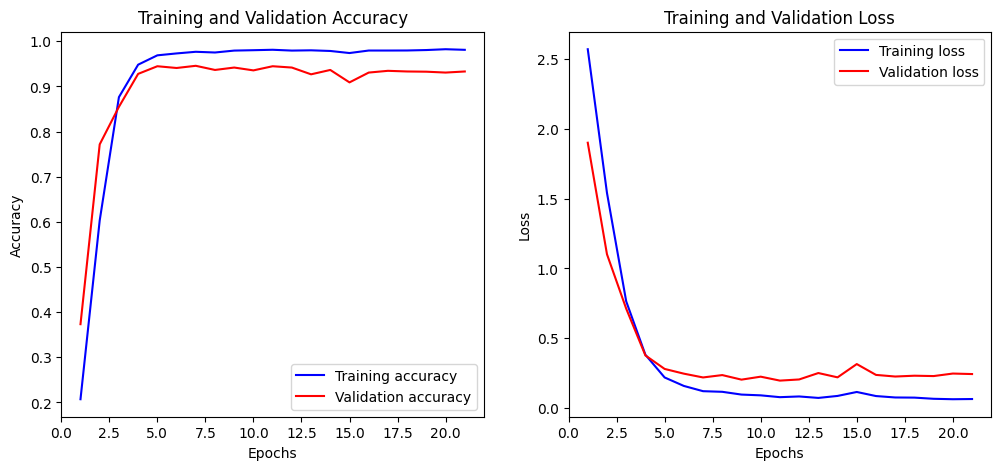

In [75]:
plt.figure(figsize=(12, 5))
# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [76]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9439 - loss: 0.1982
Test Accuracy: 0.9449
Test Loss: 0.1973


In [77]:
# Predictions on Test Data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1) 
# Finds the index of maximum probability

y_pred_classes[:10]

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


array([12,  8,  3, 12,  3,  1,  3,  0, 12,  9])

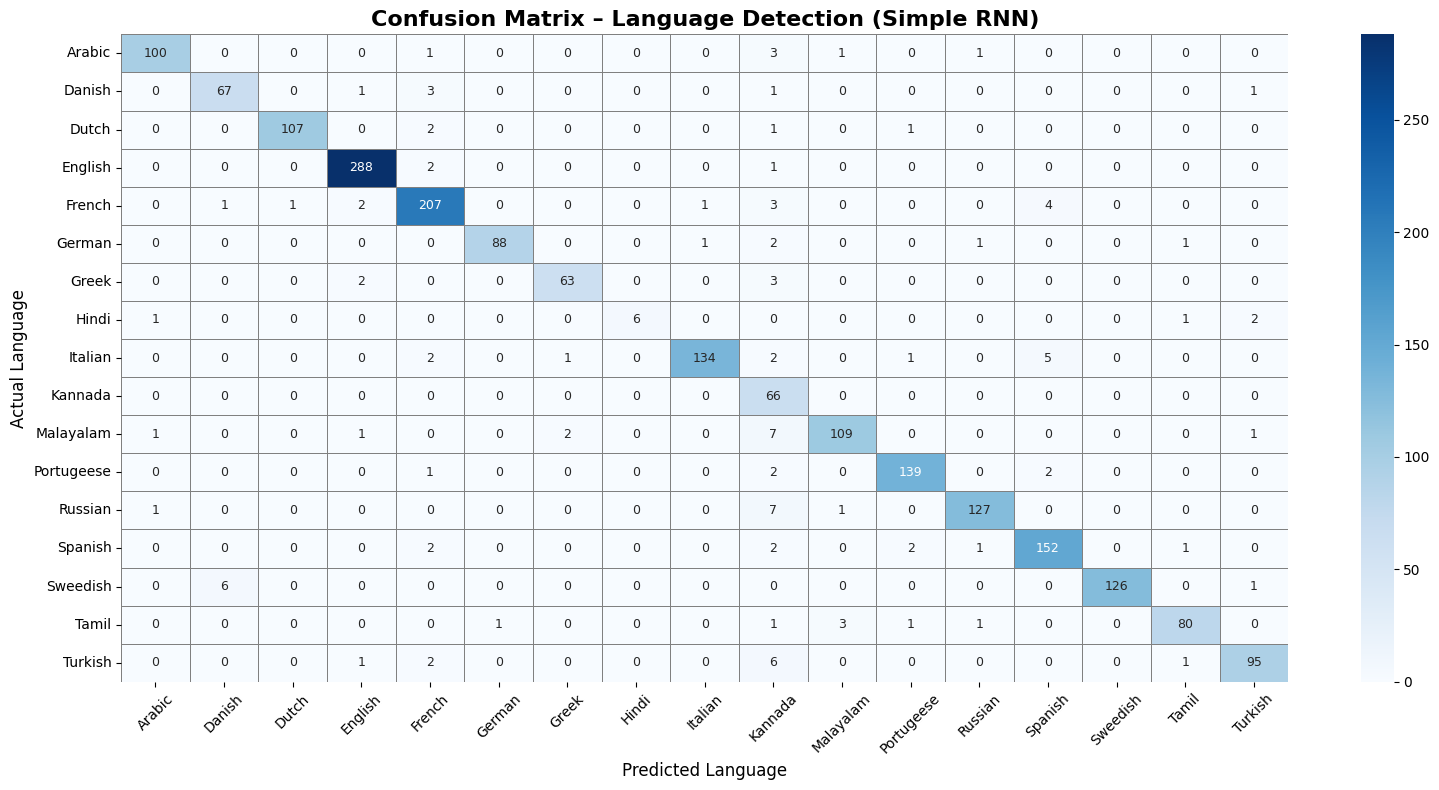

In [78]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(16, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    linecolor="grey",
    xticklabels=classes_,
    yticklabels=classes_,
    annot_kws={"size": 9}
)

plt.title("Confusion Matrix – Language Detection (Simple RNN)", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Language", fontsize=12)
plt.ylabel("Actual Language", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
df.isnull().sum()

Text        0
Language    0
dtype: int64

In [27]:
df.duplicated().sum()

np.int64(66)

In [28]:
df.drop_duplicates(inplace=True)

In [29]:
df.shape

(10271, 2)

In [30]:
data.shape

(10271, 2)

In [31]:
df.columns

Index(['Text', 'Language'], dtype='object')

## Split

In [ ]:
x = df.drop('Language', axis=1)
y = df['Text']

In [ ]:
cat_columns = x.select_dtypes(include = 'object').columns